# Data Post-Evaluation
## This notebook takes in model outputs from a Debug Data CSV and reexamines it

In [1]:
### imports

# external modules
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import importlib
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model, Sequential, load_model
import importlib
import pickle
import math
from sklearn.preprocessing import StandardScaler

# local modules
sys.path.append('../utils')
import csv_utils as csvu
import json_utils as jsonu
import dataframe_utils as dfu
import hist_utils as hu
import autoencoder_utils as aeu
import plot_utils as pu
import generate_data_utils as gdu
import refruns_utils as rru
importlib.reload(csvu)
importlib.reload(jsonu)
importlib.reload(dfu)
importlib.reload(hu)
importlib.reload(aeu)
importlib.reload(pu)
importlib.reload(gdu)
importlib.reload(rru)
sys.path.append('../src')
sys.path.append('../src/classifiers')
sys.path.append('../src/cloudfitters')
import HistStruct
importlib.reload(HistStruct)
import SubHistStruct
importlib.reload(SubHistStruct)
import FlexiStruct
importlib.reload(FlexiStruct)
import DataLoader
importlib.reload(DataLoader)
import AutoEncoder
importlib.reload(AutoEncoder)
import SeminormalFitter
import GaussianKdeFitter
import HyperRectangleFitter
importlib.reload(SeminormalFitter)
importlib.reload(GaussianKdeFitter)
importlib.reload(HyperRectangleFitter)

2022-07-29 22:40:48.859291: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.3-88592/x86_64-centos7-gcc11-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.3-35f7a/x86_64-centos7-gcc11-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/jaxlib/mlir/_mlir_libs:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/onnxruntime/capi/:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow/contrib

<module 'HyperRectangleFitter' from '/eos/home-i01/k/khowey/SWAN_projects/ML4DQMDC-PixelAE/Support Notebooks/../src/cloudfitters/HyperRectangleFitter.py'>

In [2]:
### Controls
wpBiasFactor = 20
fmBiasFactor = 2

# Select a Job to examine
job = 100

badDataLength = 6

datadir = '../Output Data/DebugData/'

In [3]:
### Select out the data we want
mse_train = np.loadtxt(datadir + 'Train/T{}.csv'.format(job),delimiter = ",")
mse_good_eval = np.loadtxt(datadir + 'Good/G{}.csv'.format(job),delimiter = ",")
mse_bad_eval = []
for i in range(badDataLength):
    mse_bad_eval.append(np.loadtxt(datadir + 'Bad/B{}p{}.csv'.format(job, i),delimiter = ","))

In [25]:
### Print information about raw MSE data
def evaluate_autoencoders_RAW(mse_good_eval, mse_bad_list, wpData):
    
    workingPoints = wpData[0]
    print(workingPoints)
    
    # Prepare data for comparison to WP
    mse_good_test = np.array(mse_good_eval[int(wp_test_split * len(mse_good_eval)):])
    mse_bad_eval = np.concatenate(tuple(mse_bad_list))
    mse_bad_test = mse_bad_eval[int(wp_test_split * len(mse_bad_eval)):]
    
    labels_good = np.zeros(len(mse_good_test))
    labels_bad = np.ones(len(mse_bad_test))
    
    # Percentage of histograms with issues to flag an anomaly
    testWeight = 1
    # Check each histogram and if a sufficient number are anomalous, flag the lumisection
    anomalousList = []
    preds_good = np.zeros(len(mse_good_test))
    for i,lumi in enumerate(mse_good_test):
        value = 0
        for j,mse in enumerate(lumi):
            if mse > workingPoints[j]:
                value += 1
        if value > 0:
            preds_good[i] = 1

    
    # Same, but with known bad data
    preds_bad = np.ones(len(mse_bad_test))
    for i, lumi in enumerate(mse_bad_test):
        value = 0
        for j,mse in enumerate(lumi):
            if mse > workingPoints[j]:
                value += 1
        if value > 0:
            preds_bad[i] = 0
            
    labels = np.concatenate(tuple([labels_good, labels_bad]))
    scores = np.concatenate(tuple([preds_good, preds_bad]))
    
    for i in range(len(workingPoints)):
        plotMSE(mse_good_eval, mse_bad_eval, workingPoints, i)
    
    (_, _, _, tp, fp, tn, fn) = aeu.get_confusion_matrix(scores,labels)
    
    print(tp)
    print(fp)
    print(tn)
    print(fn)
    
    # Get metrics for analysis
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_measure = (1 + fmBiasFactor * fmBiasFactor) * ((precision * recall) / ((fmBiasFactor * fmBiasFactor * precision) + recall)) 
    
    print('Accuracy: ' + str(accuracy))
    print('Precision: ' + str(precision))
    print('Recall: ' + str(recall))
    print('F-Measure: ' + str(f_measure))

In [26]:
### Simple plotting function for different MSEs
def plotMSE(mse_good_all, mse_bad_all, wps, histIndex):
    mse_good = mse_good_all[histIndex]
    mse_bad = mse_bad_all[histIndex]
    wp = wps[histIndex]
    
    maxVal = np.max((mse_good, mse_bad))
    oOM = math.floor(math.log(maxVal, 10))
    if oOM < 0: oOM *= -1
    labels = ((np.zeros(len(mse_good))))
    scores = ((mse_good))
    
    
    (fig, ax) = pu.plot_score_dist(scores, labels, siglabel='anomalous', sigcolor='r', 
                       bcklabel='good', bckcolor='g', 
                       nbins=200, normalize=True,
                       xaxtitle='negative logarithmic probability',
                       yaxtitle='number of lumisections (normalized)',
                       doshow=False)
    plt.axvline(x=wp, color='b', label='WP')
    plt.show()
    print(wp)

In [27]:
evaluate_autoencoders_RAW(mse_good_eval, mse_bad_eval, wpData)

NameError: name 'wpData' is not defined

In [7]:
### Plots and Distribution Analysis
def fit_mse_distribution(mse_train):
    dimslist = []
    fitfunclist = []
    
    
    nhisttypes = 96
    for i in range(0,nhisttypes-1):
        for j in range(i+1,nhisttypes):
            dimslist.append((i, j))
    
    plt.close('all')
    (npoints,ndims) = mse_train.shape
    
    
    # settings for GaussianKdeFitter
    scott_bw = npoints**(-1./(ndims+4))
    bw_method = 20*scott_bw
    # settings for HyperRectangleFitter
    quantiles = ([0.00062,0.0006,0.00015,0.00015,
                 0.0003,0.0003,0.00053,0.00065])
    
    
    #for dims in dimslist:
    #    thismse = mse_train[:,dims]
    #    if training_mode=='global': 
    #        fitfunc = SeminormalFitter.SeminormalFitter(thismse)
    #        #fitfunc = HyperRectangleFitter.HyperRectangleFitter(thismse, 
    #        #                                                    [quantiles[dims[0]],quantiles[dims[1]]],
    #        #                                                    'up')
    #    else: fitfunc = GaussianKdeFitter.GaussianKdeFitter(thismse,bw_method=bw_method)
    #    #pu.plot_fit_2d(thismse, fitfunc=fitfunc, logprob=True, clipprob=True,
    #    #                onlycontour=False, xlims=30, ylims=30, 
    #    #                onlypositive=True, transparency=0.5,
    #    #                xaxtitle=histstruct.histnames[dims[0]], 
    #    #                yaxtitle=histstruct.histnames[dims[1]],
    #    #                title='density fit of lumisection MSE')
    #    ##plt.close('all') # release plot memory
    #    fitfunclist.append(fitfunc)
    # 
    #    
    fitfunc = GaussianKdeFitter.GaussianKdeFitter()
    fitfunc.fit(mse_train,bw_method=bw_method)
    
    return fitfunc

In [8]:
fitfunc = fit_mse_distribution(mse_train)

In [21]:
### Prepare MSEs for Working Point Definition
def mse_analysis(mse_good_eval, mse_bad_eval, fitfunc):
    
    # Get the minimum log probability of histograms in good set
    print('--- good lumesections ---')
    logprob_good = np.log(fitfunc.pdf(mse_good_eval))
    print('length of log prob array: '+str(len(logprob_good)))
    print('minimum of log prob: '+str(np.min(logprob_good)))
    #print(sorted(logprob_good))
    
    print('--- bad lumisections ---')
    logprob_bad_parts = [np.log(fitfunc.pdf(mse_bad_eval[j])) for j in range(len(mse_bad_eval))]
    #for lp in logprob_bad_parts: print(str(sorted(lp))+'\n\n')
    logprob_bad = np.concatenate(tuple(logprob_bad_parts[1:]))
    
    print('length of log prob array: '+str(len(logprob_bad)))
    print('maximum of log prob: '+str(np.max(logprob_bad)))
    #print(sorted(logprob_good))
    #print(sorted(logprob_bad))
    print(logprob_bad)
    
    sep = np.min(logprob_good) - np.max(logprob_bad)
    print('Separability: ' + str(sep))
    
    return [logprob_good, logprob_bad, logprob_bad_parts]

In [22]:
(logprob_good, logprob_bad, logprob_bad_parts) = mse_analysis(mse_good_eval, mse_bad_eval, fitfunc)

--- good lumesections ---


/tmp/ipykernel_154495/2817021748.py:6: RuntimeWarning: divide by zero encountered in log
  logprob_good = np.log(fitfunc.pdf(mse_good_eval))


length of log prob array: 3496
minimum of log prob: -inf
--- bad lumisections ---


/tmp/ipykernel_154495/2817021748.py:12: RuntimeWarning: divide by zero encountered in log
  logprob_bad_parts = [np.log(fitfunc.pdf(mse_bad_eval[j])) for j in range(len(mse_bad_eval))]


length of log prob array: 553
maximum of log prob: 520.095181115905
[519.36286883 519.22749024 519.26696389 519.1587297  519.32651576
 519.28817129 519.29567195 519.21457923 519.23469749 519.20064592
 519.32515031 519.29550642 519.13773247 519.34489193 519.20922458
 519.33888751 519.15053156 519.21708706 519.30528128 519.33208084
 519.34612645 519.29604922 519.28878235 519.45418323 519.30220435
 519.24846752 519.27615654 519.38448744 519.28332881 519.23180033
 519.40378509 519.29473777 519.17994895 519.1505588  519.22906151
 519.24477562 519.32881852 519.24589428 519.3523851  519.32036154
 519.27114833 519.38606061 519.2054425  519.25500181 519.04379675
 519.24790147 519.28708843 519.27632707 519.30624082 519.31440629
 519.47578408 519.20719384 519.29498355 519.15301097 519.36166991
 519.30359652 519.36637507 519.12108677 519.26295299 519.35601118
 519.27931984 519.10430651 519.33913434 519.08573561 519.24773366
 519.19826137 519.35446907 519.00215913 519.1773908  519.26062154
 519.158

In [23]:
def evaluate_autoencoders_combined(logprob_good, logprob_bad, fmBiasFactor, wpBiasFactor):
    labels_good = np.zeros(len(logprob_good)) # background: label = 0
    labels_bad = np.ones(len(logprob_bad)) # signal: label = 1
    
    badMin = min(np.where(logprob_bad != -np.inf, logprob_bad, -1))
    goodMax = max(np.where(logprob_good != np.inf, logprob_good, 10001))
    
    if np.isnan(goodMax): goodMax = 800
    if np.isnan(badMin): badMin = 0
    
    logprob_good = np.where(logprob_good != np.inf, logprob_good, goodMax)
    logprob_bad = np.where(logprob_bad != -np.inf, logprob_bad, badMin)
    
    # These only take effect if a histogram is grossly misclassified
    logprob_good[logprob_good == -np.inf] = badMin
    logprob_bad[logprob_bad == np.inf] = goodMax
    
    labels = np.concatenate(tuple([labels_good,labels_bad]))
    scores = np.concatenate(tuple([-logprob_good,-logprob_bad]))
    scores = aeu.clip_scores( scores )
    
    avSep = np.mean(logprob_good) - np.mean(logprob_bad)
    
    print('Average Separation: ' + str(avSep))
    
    # Setting a threshold, below this working point defines anomalous data
    # Average is biased towards better recall per user specifications
    logprob_threshold = (1/(wpBiasFactor + 1)) * (wpBiasFactor*np.mean(logprob_good) + np.mean(logprob_bad))
    # Or set manual
    # logprob_threshold = 400 
    
    
    mis = np.where((labels==1) & (scores<-logprob_threshold),1,0).astype(bool)
    labels2 = np.where(mis, 0, labels)
    mis = np.where((labels2==0) & (scores>-logprob_threshold),1,0).astype(bool)
    labels2 = np.where(mis, 1, labels2)
    np.savetxt('../KH-AutoencoderTest/Labels.csv', labels2, delimiter=',')
    
    (fig, ax) = pu.plot_score_dist(scores, labels, siglabel='anomalous', sigcolor='r', 
                       bcklabel='good', bckcolor='g', 
                       nbins=200, normalize=True,
                       xaxtitle='negative logarithmic probability',
                       yaxtitle='number of lumisections (normalized)',
                       doshow=False)
    plt.axvline(x=-logprob_threshold, color='b', label='WP')
    plt.show()
      
    # Plot ROC curve for analysis
    auc = aeu.get_roc(scores, labels, mode='geom', doprint=False)
    
    (_, _, _, tp, fp, tn, fn) = aeu.get_confusion_matrix(scores, labels,-logprob_threshold)
    print('Selected logprob threshold of ' + str(logprob_threshold))
    
    # Get metrics for analysis
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_measure = (1 + fmBiasFactor * fmBiasFactor) * ((precision * recall) / ((fmBiasFactor * fmBiasFactor * precision) + recall)) 
    
    print('Accuracy: ' + str(accuracy))
    print('Precision: ' + str(precision))
    print('Recall: ' + str(recall))
    print('F-Measure: ' + str(f_measure))
    
    return logprob_threshold, labels2

Average Separation: -92.73745345781424


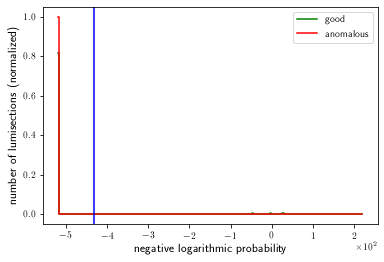

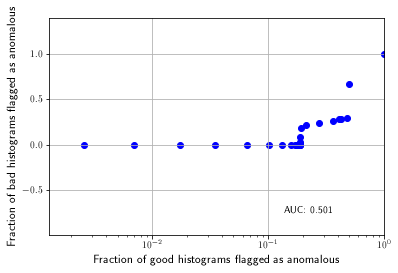

Selected logprob threshold of 431.5167767625448
Accuracy: 0.40903890160183065
Precision: 0.0
Recall: 0.0
F-Measure: nan


/tmp/ipykernel_154495/1391010260.py:58: RuntimeWarning: invalid value encountered in double_scalars
  f_measure = (1 + fmBiasFactor * fmBiasFactor) * ((precision * recall) / ((fmBiasFactor * fmBiasFactor * precision) + recall))


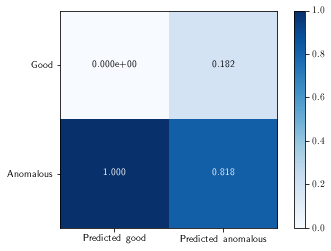

In [24]:
logprob_threshold, labels2 = evaluate_autoencoders_combined(logprob_good, logprob_bad, fmBiasFactor, wpBiasFactor)

In [17]:
def evaluate_autoencoders_combined_fix(logprob_good, logprob_bad, fmBiasFactor, wpBiasFactor, labels2):
    labels = labels2
    labels_good = np.zeros(len(logprob_good)) # background: label = 0
    labels_bad = np.ones(len(logprob_bad)) # signal: label = 1
    
    badMin = min(np.where(logprob_bad != -np.inf, logprob_bad, -1))
    goodMax = max(np.where(logprob_good != np.inf, logprob_good, 10001))
    
    logprob_good = np.where(logprob_good != np.inf, logprob_good, goodMax)
    logprob_bad = np.where(logprob_bad != -np.inf, logprob_bad, badMin)
    
    # These only take effect if a histogram is grossly misclassified
    logprob_good[logprob_good == -np.inf] = badMin
    logprob_bad[logprob_bad == np.inf] = goodMax
    
    scores = np.concatenate(tuple([-logprob_good,-logprob_bad]))
    scores = aeu.clip_scores( scores )
    
    avSep = np.mean(logprob_good) - np.mean(logprob_bad)
    
    print('Average Separation: ' + str(avSep))
    
    # Setting a threshold, below this working point defines anomalous data
    # Average is biased towards better recall per user specifications
    logprob_threshold = (1/(wpBiasFactor + 1)) * (wpBiasFactor*np.mean(logprob_good) + np.mean(logprob_bad))
    # Or set manual
    # logprob_threshold = 400 
    
    goodPos = np.mean(logprob_good)
    badPos = np.mean(logprob_bad)
    
    (fig, ax) = pu.plot_score_dist(scores, labels2, siglabel='anomalous', sigcolor='r', 
                       bcklabel='good', bckcolor='g', 
                       nbins=200, normalize=True,
                       xaxtitle='negative logarithmic probability',
                       yaxtitle='number of lumisections (normalized)',
                       doshow=False)
    plt.axvline(x=-logprob_threshold, color='b', label='WP')
    plt.show()
      
    # Plot ROC curve for analysis
    auc = aeu.get_roc(scores, labels2, mode='geom', doprint=False)
    
    (_, _, _, tp, fp, tn, fn) = aeu.get_confusion_matrix(scores, labels2,-logprob_threshold)
    print('Selected logprob threshold of ' + str(logprob_threshold))
    
    # Get metrics for analysis
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_measure = (1 + fmBiasFactor * fmBiasFactor) * ((precision * recall) / ((fmBiasFactor * fmBiasFactor * precision) + recall)) 
    
    print('Accuracy: ' + str(accuracy))
    print('Precision: ' + str(precision))
    print('Recall: ' + str(recall))
    print('F-Measure: ' + str(f_measure))
    
    return logprob_threshold, goodPos, badPos

Average Separation: 80.47097259773835


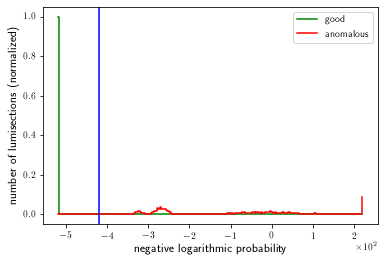

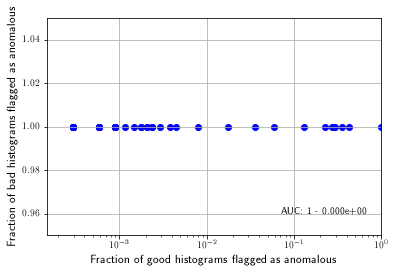

Selected logprob threshold of 419.8919270660517
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F-Measure: 1.0


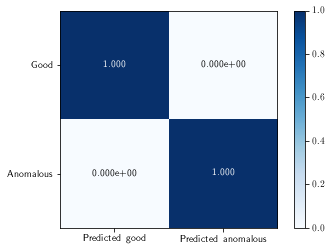

In [18]:
(logprob_threshold, goodPos, badPos) = evaluate_autoencoders_combined_fix(logprob_good, logprob_bad, fmBiasFactor, wpBiasFactor, labels2)

In [19]:
def evaluate_autoencoders_individual(logprob_good, logprob_bad, fmBiasFactor, wpBiasFactor, logprob_bad_parts, goodPos, badPos):
    for i,logprob_bad in enumerate(logprob_bad_parts):
        
        labels_good = np.zeros(len(logprob_good)) # background: label = 0
        labels_bad = np.ones(len(logprob_bad)) # signal: label = 1
        
        badMin = min(np.where(logprob_bad != -np.inf, logprob_bad, -1))
        goodMax = max(np.where(logprob_good != np.inf, logprob_good, 10001))
        
        logprob_good = np.where(logprob_good != np.inf, logprob_good, goodMax)
        logprob_bad = np.where(logprob_bad != -np.inf, logprob_bad, badMin)
        
        # These only take effect if a histogram is grossly misclassified
        logprob_good[logprob_good == -np.inf] = badMin
        logprob_bad[logprob_bad == np.inf] = goodMax
        
        labels = labels_bad
        scores = -logprob_bad
        scores = aeu.clip_scores( scores )
    
        print('Showing Data from Bad Run ' + str(i))
        (fig, ax) = pu.plot_score_dist(scores, labels, siglabel='anomalous', sigcolor='m', 
                           bcklabel='good', bckcolor='k', 
                           nbins=200, normalize=True,
                           xaxtitle='negative logarithmic probability',
                           yaxtitle='number of lumisections (normalized)', doshow=False)
        
        plt.axvline(x=-logprob_threshold, color='b', label='WP', linestyle='-')
        plt.axvline(x=-goodPos, color='g', label='Good Avg', linestyle='-.')
        plt.axvline(x=-badPos, color='r', label='Bad Avg', linestyle='--')
        plt.show()

Showing Data from Bad Run 0


/eos/home-i01/k/khowey/SWAN_projects/ML4DQMDC-PixelAE/Support Notebooks/../utils/plot_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  bckhist = bckhist/np.sum(bckhist)


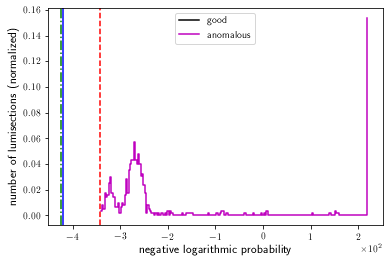

Showing Data from Bad Run 1


/eos/home-i01/k/khowey/SWAN_projects/ML4DQMDC-PixelAE/Support Notebooks/../utils/plot_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  bckhist = bckhist/np.sum(bckhist)


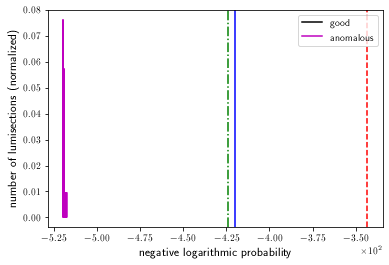

Showing Data from Bad Run 2


/eos/home-i01/k/khowey/SWAN_projects/ML4DQMDC-PixelAE/Support Notebooks/../utils/plot_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  bckhist = bckhist/np.sum(bckhist)


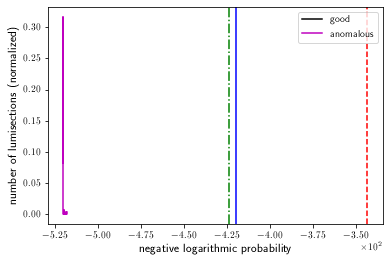

Showing Data from Bad Run 3


/eos/home-i01/k/khowey/SWAN_projects/ML4DQMDC-PixelAE/Support Notebooks/../utils/plot_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  bckhist = bckhist/np.sum(bckhist)


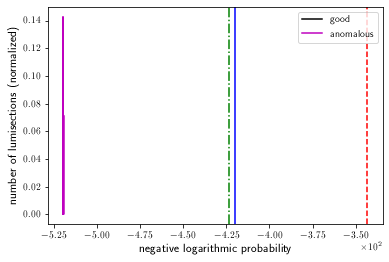

Showing Data from Bad Run 4


/eos/home-i01/k/khowey/SWAN_projects/ML4DQMDC-PixelAE/Support Notebooks/../utils/plot_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  bckhist = bckhist/np.sum(bckhist)


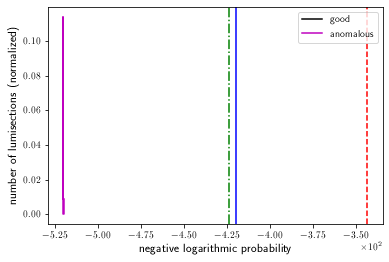

Showing Data from Bad Run 5


/eos/home-i01/k/khowey/SWAN_projects/ML4DQMDC-PixelAE/Support Notebooks/../utils/plot_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  bckhist = bckhist/np.sum(bckhist)


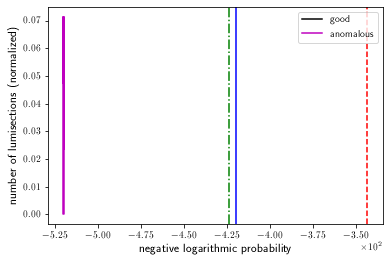

In [20]:
evaluate_autoencoders_individual(logprob_good, logprob_bad, fmBiasFactor, wpBiasFactor, logprob_bad_parts, goodPos, badPos)